# Code examples to use the CAEVizT model

## Préparer le modèle

In [1]:
from cae import CAEVizT
from core.helpers import make_sequences

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

sns.set_palette("tab10")
sns.set_style("whitegrid")

In [3]:
# Generate some example data (multivariate time series)
n_samples = 2000
seq_len = 30
n_features = 1

# Create sine waves with different frequencies as an example
time = np.linspace(0, n_samples, 1)
X = np.sin(time + np.random.normal(0, 1, n_samples)) * 0.3 + np.random.normal(0, 0.7, n_samples)
X = X.reshape(n_samples, n_features)
print("Original shape :", X.shape)

X_seq = make_sequences(X, seq_len=seq_len, shuffle=False)
print("Sequences shape :", X_seq.shape)

example_data = np.random.choice(n_samples-seq_len, size=5, replace=False)

Original shape : (2000, 1)
Sequences shape : (1970, 30, 1)


In [4]:
model = CAEVizT(
    input_shape=X_seq.shape[1:],
    latent_dim=6,
    filters=[16, 32],
    clustering_model='kmeans',
    n_clusters=10,
    top_k=2,
    seq_len=seq_len
)

In [5]:
model = model.fit(X_seq, 
            batch_size=32, 
            verbose=1, 
            stats_window=30,
            epochs=30,
            pretraining_epochs=10,
            spectrum_epochs=30
            )

=== Pre-training Phase ===
Epoch 1/10
56/56 [==============================] - 8s 21ms/step - loss: 16.0097 - val_loss: 15.7555
Epoch 2/10
56/56 [==============================] - 1s 10ms/step - loss: 15.3767 - val_loss: 14.8699
Epoch 3/10
56/56 [==============================] - 1s 10ms/step - loss: 14.8596 - val_loss: 14.4052
Epoch 4/10
56/56 [==============================] - 1s 11ms/step - loss: 14.5309 - val_loss: 14.1136
Epoch 5/10
56/56 [==============================] - 1s 12ms/step - loss: 14.2432 - val_loss: 14.1636
Epoch 6/10
56/56 [==============================] - 1s 12ms/step - loss: 13.9424 - val_loss: 13.5711
Epoch 7/10
56/56 [==============================] - 1s 12ms/step - loss: 13.6832 - val_loss: 13.3564
Epoch 8/10
56/56 [==============================] - 1s 11ms/step - loss: 13.5052 - val_loss: 13.1670
Epoch 9/10
56/56 [==============================] - 1s 11ms/step - loss: 13.4233 - val_loss: 13.2138
Epoch 10/10
56/56 [==============================] - 1s 12ms/ste

## Utilisations et analyse permises par le modèle CAEVizT

---

## Analyse des séquences temporelles de clusters

> A l'aide d'un `RandomForestClassifier`.

In [6]:
from insights.clusters import \
    analyse_cluster_sequences, \
    plot_random_forest_results

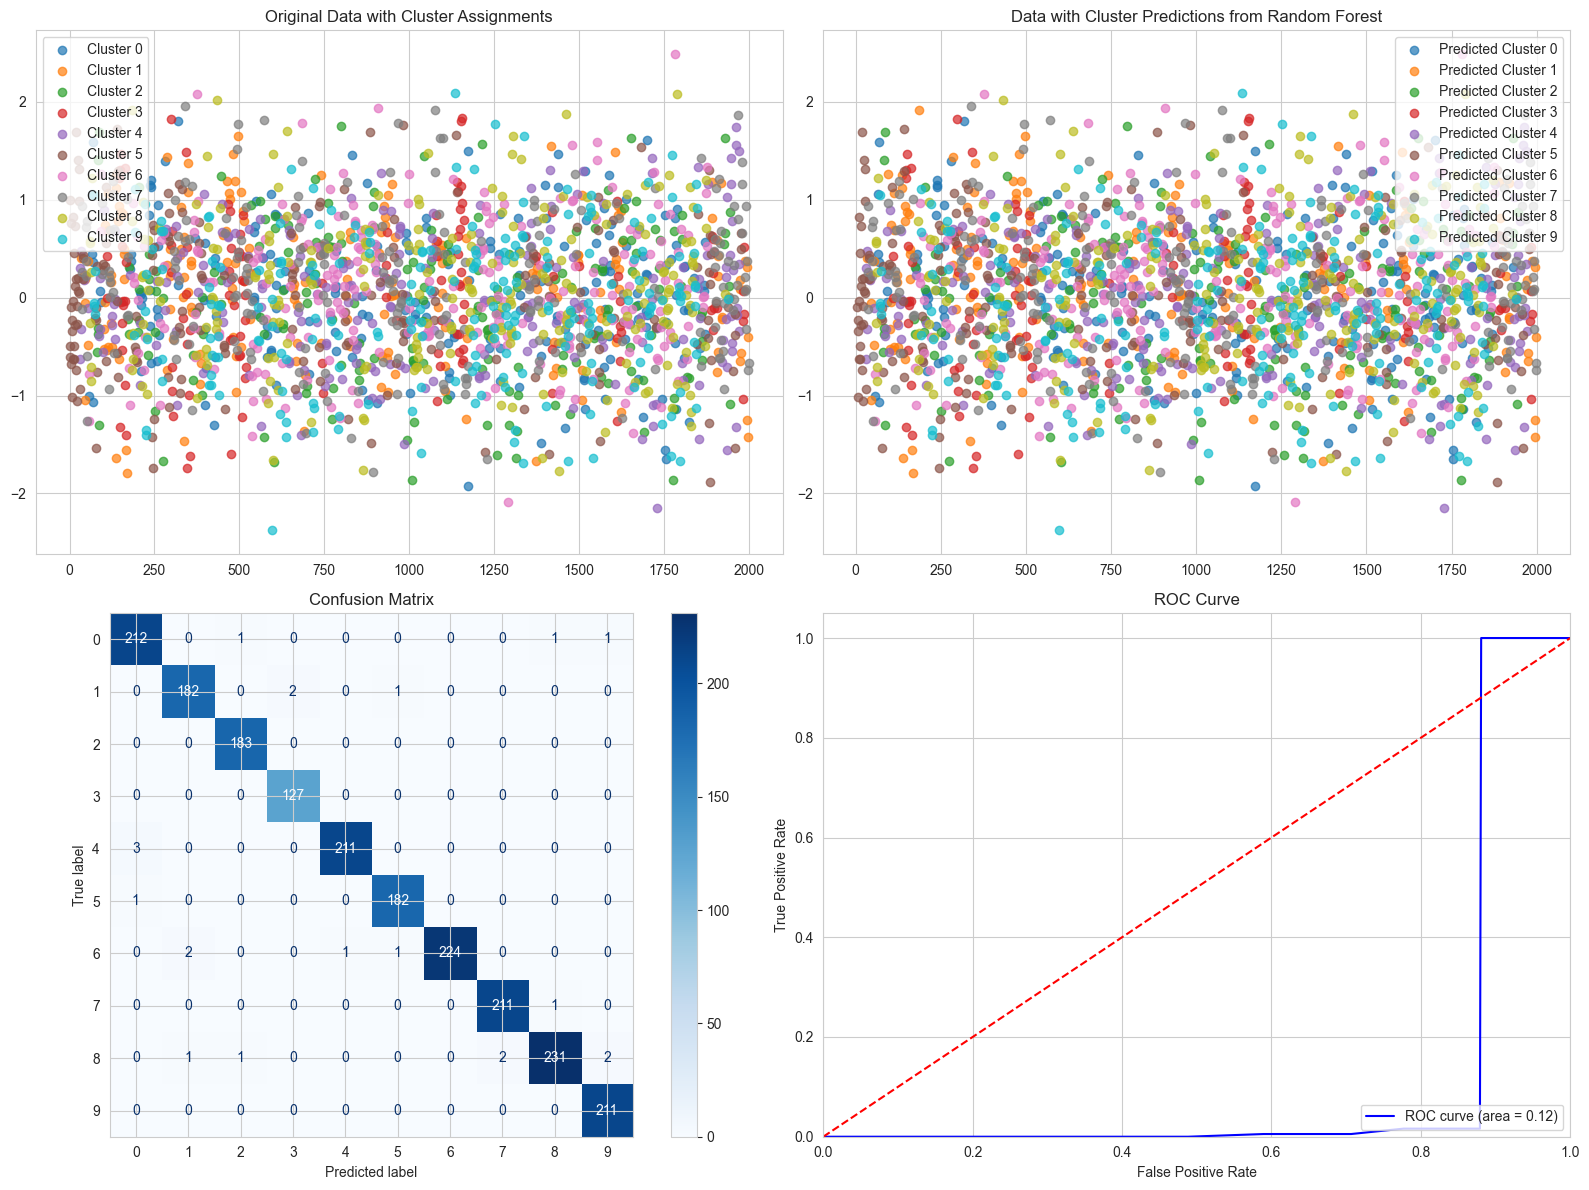

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       215
           1       0.98      0.98      0.98       185
           2       0.99      1.00      0.99       183
           3       0.98      1.00      0.99       127
           4       1.00      0.99      0.99       214
           5       0.99      0.99      0.99       183
           6       1.00      0.98      0.99       228
           7       0.99      1.00      0.99       212
           8       0.99      0.97      0.98       237
           9       0.99      1.00      0.99       211

    accuracy                           0.99      1995
   macro avg       0.99      0.99      0.99      1995
weighted avg       0.99      0.99      0.99      1995



In [7]:
window_size = 5
point_labels, predictions = analyse_cluster_sequences(
    X, X_seq, model, seq_len, n_estimators=10
)
plot_random_forest_results(X, point_labels, predictions, window_size=window_size)

## Analyse par spectre de comportement

In [8]:
from insights.spectrum import \
    spectrum_projection, \
    plot_spectrum_projection

In [9]:
X_pred, X_pred_upper, X_pred_lower = spectrum_projection(
    X, model, seq_len, scale=2.0
)

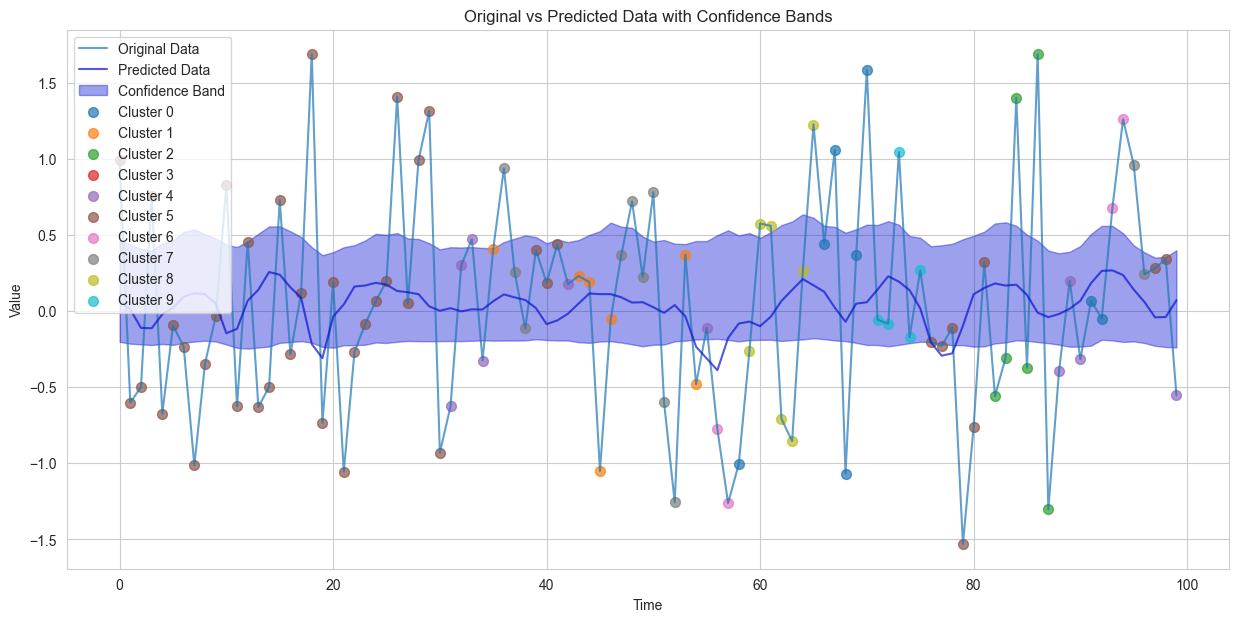

In [10]:
# Compare original and predicted sequences with confidence intervals
len_to_plot = 100
plot_spectrum_projection(
    X, # Or be used with other more specific data (better then the whole dataset), without len_to_plot
    X_pred,
    X_pred_upper,
    X_pred_lower,
    point_labels,
    len_to_plot=len_to_plot
)

## Analyse de motifs par clusters

> Où chercher des motifs récurrents dans les données, tels qu'ils sont classifiés par le modèle.

In [263]:
import insights.clusters as clusters
from importlib import reload
reload(clusters)

<module 'insights.clusters' from 'c:\\Users\\leo.logel\\Workspace\\IA\\Prediction_compteurs_SDEA\\ds-efficiency-target-ml\\MachineLearning\\caevizt\\insights\\clusters.py'>

In [264]:
from insights.clusters import ClusterInfoExtractor
from cae_projection import CAEVizTProjection

In [265]:
cie = ClusterInfoExtractor(model)
projector = CAEVizTProjection(model)
decoder = projector.decoder
cluster_info = cie.extract_cluster_info(X_seq, projector.decoder)
palette = ClusterInfoExtractor.get_color_palette(len(cluster_info['unique_clusters']))

Avec ces statistiques, on représente les différentes distributions dans chacun des clusters. 
La méthode est telle que :
- le modèle entraîné a définit des clusters, dans son espace latent.
- on génère des données artificielles (selon 3 méthodes et une qui les combinent) pour "remplir" (_flood_) l'espace latent et donc obtenir la "vraie étendue/dimension" des clusters.
- la projection de ces données générées à travers le _decoder_ obtient donc des "faux relevés" représentatifs des comportements observés dans chacun des clusters.

Cette évaluation permet alors d'établir des groupes de comportements, et donc notamment le paramètre `anomalia_clusters`.

In [268]:
cluster_info['anomalia_clusters']

[0, 2]

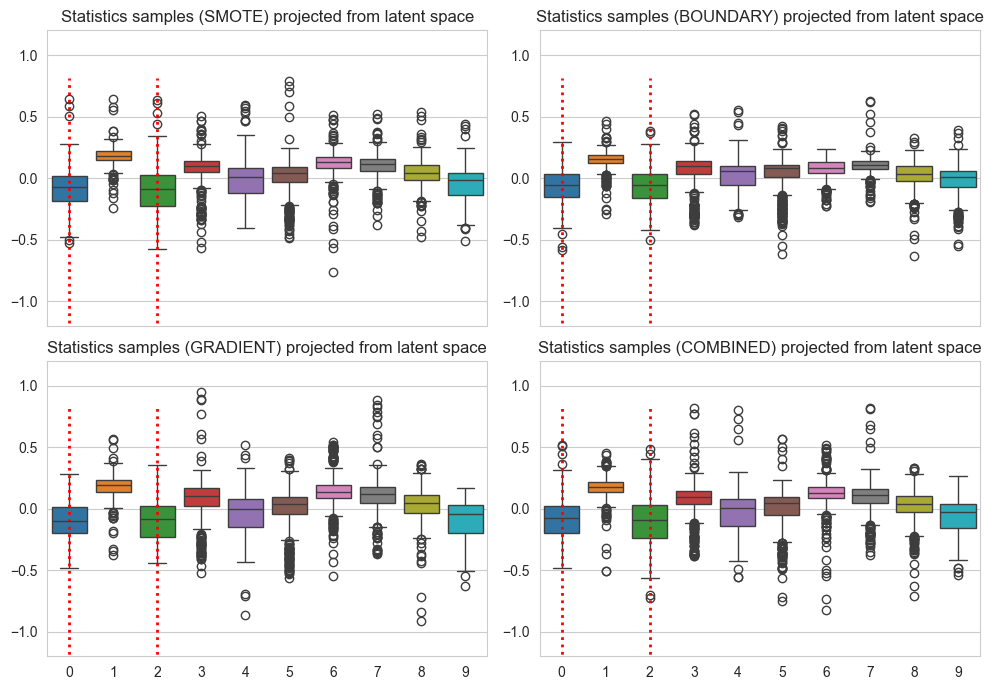

In [269]:
cie.visualize_cluster_distributions(decoder, cluster_info, seq_len)

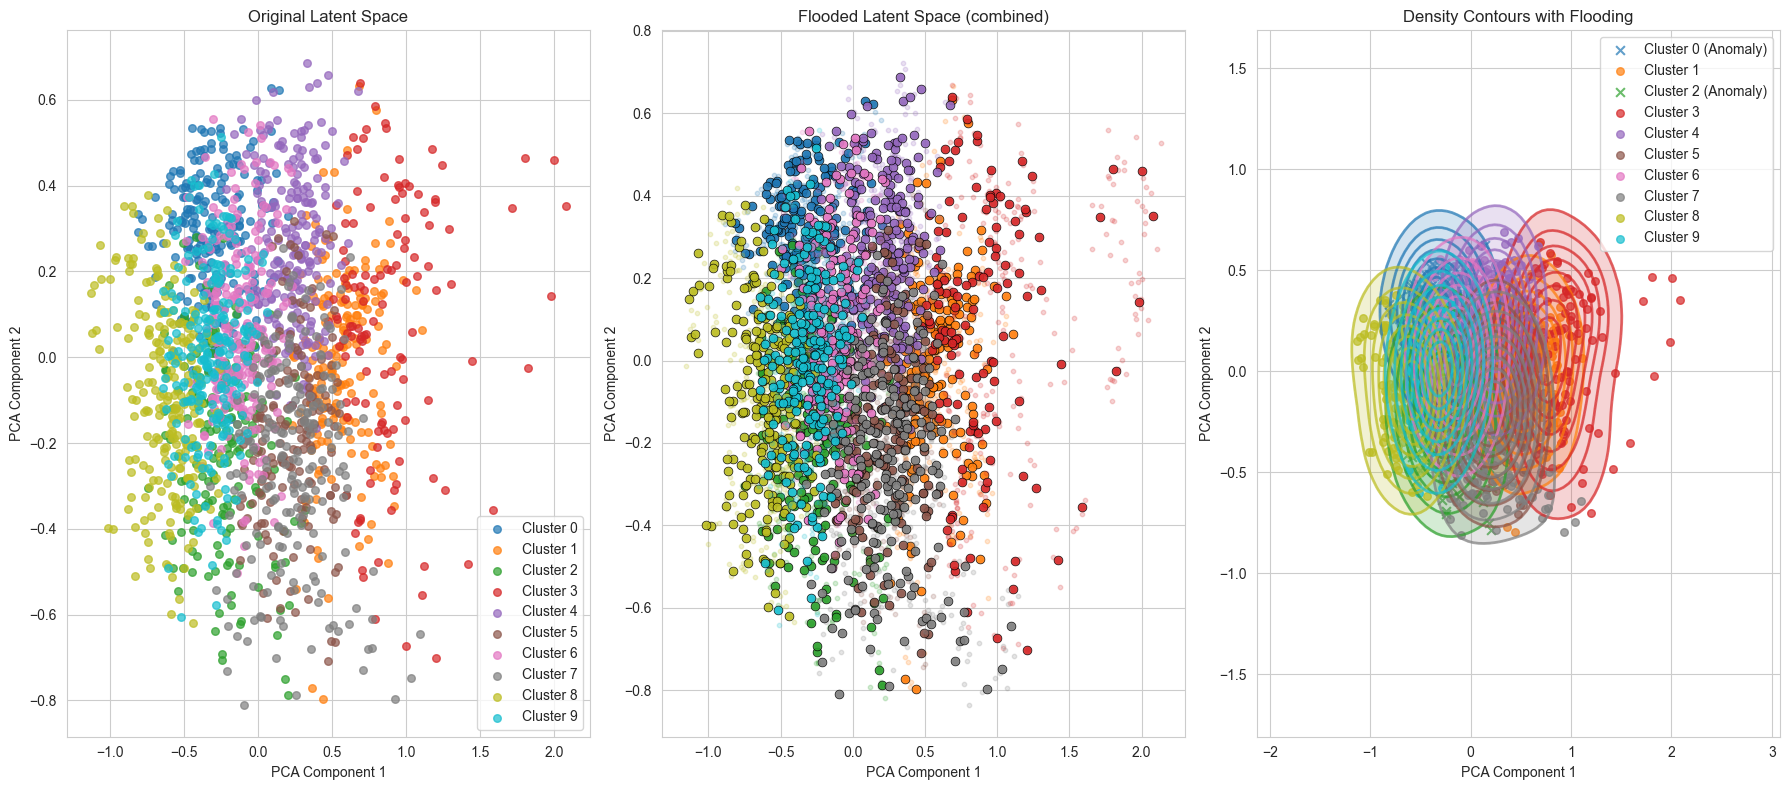

In [271]:
# fig1, _ = projector.plot_flooded_latent_space(X_seq, flood_method='smote')

# fig2, _ = projector.plot_flooded_latent_space(X_seq, flood_method='gradient')

# fig3, _ = projector.plot_flooded_latent_space(X_seq, flood_method='boundary')

fig4, latent_samples = projector.plot_flooded_latent_space(X_seq, flood_method='combined', anomalia_clusters=cluster_info['anomalia_clusters'])